## Classification of research papers

#### Topics

1.0 Importing packages and loading data

    1.1 About arXiv Dataset
    
    1.2 Loading the dataset

    1.3 Exploratory Data Analysis (EDA)
    
    1.4 Balancing the dataset

2.0 Cleaning text for analysis

3.0 Plotting the wordcloud using TfIdf Vectorizer

4.0 Running different ML models

    4.1 Naive Baye's Classifier
    
    4.2 Logistic Regression Classifier
    
    4.3 LSTM using Word2Vec
    
        4.3.1 Word2Vec
        
        4.3.2 Visualizing Word2Vec Embeddings with t-SNE
        
        4.3.3 Performing LSTM
    
    4.4 BERT

5.0 Interpreting the results

## 1.0 Importing packages and loading data

Import all the packages and load the required data.

In [ ]:
import re
import gensim
import random
import numpy as np
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import BertTokenizer
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from keras import optimizers
from keras import backend as K
from keras.initializers import Constant
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 1.1 About arXiv Dataset
ArXiv has been serving the public and research communities for nearly 30 years by providing open access to scholarly articles ranging from the vast branches of physics to the many subdisciplines of computer science and everything in between, including math, statistics, electrical engineering, quantitative biology, and economics. This vast repository of data provides significant, if at times overwhelming, depth.

A repository of 1.7 million articles, with relevant features such as article titles, authors, categories, abstracts, full text PDFs, and more.

### 1.2 Loading the dataset
The downloaded data is in zip file and we need to unzip the data first.

In [ ]:
# do not run
#zf = ZipFile('archive.zip', 'r')
# zf.extractall('')
# zf.close()

The unzipped file is in json format with a size of 649MB, loading the whole file at once is impossible so we are reading the file in chunks of 100000.

In [ ]:
# do not run
# , usecols = ['id','submitter','authors','title', 'comments','journal-ref','doi','report-no','categories','license','abstract'])
# df_chunk = pd.read_json('arxiv-metadata-oai-snapshot.json', chunksize=100000, lines=True)

In [ ]:
# do not run
'''def chunk_preprocessing(df):
    df['submitter'] = df['submitter'].str.strip()
    df['authors'] = df['authors'].str.strip()
    df['title'] = df['title'].str.strip()
    df['abstract'] = df['abstract'].str.strip()
    return df'''

In [5]:
# do not run
'''chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    chunk_filter = chunk_preprocessing(chunk)
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
df_concat = pd.concat(chunk_list)
df_concat'''

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturbati...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-pe...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is describe...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle n...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\Lam...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044251,supr-con/9608008,Ruslan Prozorov,"R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...",On the origin of the irreversibility line in t...,"19 pages, LaTex, 6 PostScript figures; Author'...",None,10.1103/PhysRevB.54.15530,None,supr-con cond-mat.supr-con,None,We report on measurements of the angular depen...,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...",2009-10-30,"[[Prozorov, R., ], [Konczykowski, M., ], [Schm..."
2044252,supr-con/9609001,Durga P. Choudhury,"Durga P. Choudhury, Balam A. Willemsen, John S...",Nonlinear Response of HTSC Thin Film Microwave...,"4 pages, LaTeX type, Uses IEEE style files, 60...",None,10.1109/77.620744,None,supr-con cond-mat.supr-con,None,The non-linear microwave surface impedance of ...,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...",2016-11-18,"[[Choudhury, Durga P., , Physics Department, N..."
2044253,supr-con/9609002,Durga P. Choudhury,"Balam A. Willemsen, J. S. Derov and S.Sridhar ...",Critical State Flux Penetration and Linear Mic...,"20 pages, LaTeX type, Uses REVTeX style files,...",None,10.1103/PhysRevB.56.11989,None,supr-con cond-mat.supr-con,None,The vortex contribution to the dc field (H) de...,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...",2009-10-30,"[[Willemsen, Balam A., , Physics Department,\n..."
2044254,supr-con/9609003,Hasegawa Yasumasa,Yasumasa Hasegawa (Himeji Institute of Technol...,Density of States and NMR Relaxation Rate in A...,"7 pages, 4 PostScript Figures, LaTeX, to appea...",None,10.1143/JPSJ.65.3131,None,supr-con cond-mat.supr-con,None,We show that the density of states in an aniso...,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...",2009-10-30,"[[Hasegawa, Yasumasa, , Himeji Institute of Te..."


In [6]:
# do not run
# df_concat.to_csv('arXiv_full.csv')

# The above lines are indicated as "do not run" because they take a lot of processing times and the file is saved as csv for future use.

In [ ]:
df_concat = pd.read_csv('arXiv_full.csv')
df_concat

### 1.3 Exploratory Data Analysis (EDA)

In [3]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044256 entries, 0 to 2044255
Data columns (total 15 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   id              object
 2   submitter       object
 3   authors         object
 4   title           object
 5   comments        object
 6   journal-ref     object
 7   doi             object
 8   report-no       object
 9   categories      object
 10  license         object
 11  abstract        object
 12  versions        object
 13  update_date     object
 14  authors_parsed  object
dtypes: int64(1), object(14)
memory usage: 233.9+ MB


In [4]:
df_concat.isnull().sum()

Unnamed: 0              0
id                      0
submitter           15190
authors                 0
title                   0
comments           455043
journal-ref       1286848
doi               1007644
report-no         1874184
categories              0
license            452900
abstract                0
versions                0
update_date             0
authors_parsed          0
dtype: int64

As we see from above that we have a lot of null values  present in the columns: submitter, comments, journal-ref, doi, report-no, license.

Anyways we are interested only in the abstract, categories and title columns which doesnt have any null values. Hence we drop the other columns.

In [3]:
df_new = df_concat[['abstract', 'categories', 'title']]
df_new

,abstract,categories,title
0,A fully differential calculation in perturbati...,hep-ph,Calculation of prompt diphoton production cros...
1,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,Sparsity-certifying Graph Decompositions
2,The evolution of Earth-Moon system is describe...,physics.gen-ph,The evolution of the Earth-Moon system based o...
3,We show that a determinant of Stirling cycle n...,math.CO,A determinant of Stirling cycle numbers counts...
4,In this paper we show how to compute the $\Lam...,math.CA math.FA,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...
...,...,...,...
2044251,We report on measurements of the angular depen...,supr-con cond-mat.supr-con,On the origin of the irreversibility line in t...
2044252,The non-linear microwave surface impedance of ...,supr-con cond-mat.supr-con,Nonlinear Response of HTSC Thin Film Microwave...
2044253,The vortex contribution to the dc field (H) de...,supr-con cond-mat.supr-con,Critical State Flux Penetration and Linear Mic...
2044254,We show that the density of states in an aniso...,supr-con cond-mat.supr-con,Density of States and NMR Relaxation Rate in A...


In [5]:
df_new.isnull().sum()

abstract      0
categories    0
title         0
dtype: int64

In [6]:
df_new["categories"].unique()

array(['hep-ph', 'math.CO cs.CG', 'physics.gen-ph', ...,
       'supr-con cond-mat.mtrl-sci cond-mat.supr-con',
       'supr-con cond-mat.mtrl-sci cond-mat.supr-con nlin.PS patt-sol',
       'supr-con cond-mat.supr-con quant-ph'], dtype=object)

In [7]:
len(df_new["categories"].unique())

70330

#### From above it shows that we have nearly 70k categories but is it really true that we have so many categories? No, its not when we got through the site https://arxiv.org/, we see that we have only 7 major categories. So, we decided to change the categories to these main 7 categories. After this what we see is the main 3 categories ph, math, cs have the most of the papers as it will be shown in the plot below. So, the remaining 4 categories we have named it as other for now.

In [4]:
def get_category(text):
    x = ""
    if "ph" in text: x = "ph"
    elif "math" in text: x = "math"
    elif "cs" in text: x = "cs"
    elif "cond-mat" in text: x = "ph"
    elif "hep" in text: x = "ph"
    elif "nlin" in text: x = "ph"
    elif "nucl" in text: x = "ph"
    elif "gr" in text: x = "ph"
    else: x = "other"
    return x

In [5]:
df_new["categories_2"] = df_new["categories"].apply(lambda x: get_category(x))
df_new

C:\Users\farha\AppData\Local\Temp/ipykernel_3652/373970347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["categories_2"] = df_new["categories"].apply(lambda x: get_category(x))


,abstract,categories,title,categories_2
0,A fully differential calculation in perturbati...,hep-ph,Calculation of prompt diphoton production cros...,ph
1,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,Sparsity-certifying Graph Decompositions,math
2,The evolution of Earth-Moon system is describe...,physics.gen-ph,The evolution of the Earth-Moon system based o...,ph
3,We show that a determinant of Stirling cycle n...,math.CO,A determinant of Stirling cycle numbers counts...,math
4,In this paper we show how to compute the $\Lam...,math.CA math.FA,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math
...,...,...,...,...
2044251,We report on measurements of the angular depen...,supr-con cond-mat.supr-con,On the origin of the irreversibility line in t...,ph
2044252,The non-linear microwave surface impedance of ...,supr-con cond-mat.supr-con,Nonlinear Response of HTSC Thin Film Microwave...,ph
2044253,The vortex contribution to the dc field (H) de...,supr-con cond-mat.supr-con,Critical State Flux Penetration and Linear Mic...,ph
2044254,We show that the density of states in an aniso...,supr-con cond-mat.supr-con,Density of States and NMR Relaxation Rate in A...,ph


#### We can see below the count of the new categories and the data looks dominating by physics.

In [10]:
df_new["categories_2"].value_counts()

ph       1212704
math      461139
cs        318493
other      51920
Name: categories_2, dtype: int64

In [6]:
labels = df_new['categories_2'].unique()
labels

array(['ph', 'math', 'other', 'cs'], dtype=object)

In [7]:
label_dict = {labels[i]:i for i in range(len(labels))}
label_dict

{'ph': 0, 'math': 1, 'other': 2, 'cs': 3}

Below code will help us in converting the categorical column into numerical.

In [8]:
df_new['labels_2'] = df_new['categories_2'].map(label_dict)
df_new

C:\Users\farha\AppData\Local\Temp/ipykernel_3652/2059284148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['labels_2'] = df_new['categories_2'].map(label_dict)


,abstract,categories,title,categories_2,labels_2
0,A fully differential calculation in perturbati...,hep-ph,Calculation of prompt diphoton production cros...,ph,0
1,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,Sparsity-certifying Graph Decompositions,math,1
2,The evolution of Earth-Moon system is describe...,physics.gen-ph,The evolution of the Earth-Moon system based o...,ph,0
3,We show that a determinant of Stirling cycle n...,math.CO,A determinant of Stirling cycle numbers counts...,math,1
4,In this paper we show how to compute the $\Lam...,math.CA math.FA,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math,1
...,...,...,...,...,...
2044251,We report on measurements of the angular depen...,supr-con cond-mat.supr-con,On the origin of the irreversibility line in t...,ph,0
2044252,The non-linear microwave surface impedance of ...,supr-con cond-mat.supr-con,Nonlinear Response of HTSC Thin Film Microwave...,ph,0
2044253,The vortex contribution to the dc field (H) de...,supr-con cond-mat.supr-con,Critical State Flux Penetration and Linear Mic...,ph,0
2044254,We show that the density of states in an aniso...,supr-con cond-mat.supr-con,Density of States and NMR Relaxation Rate in A...,ph,0


Below plot shows us the count of the categories in bar chart. 

In [ ]:
print(df_new.groupby(['categories_2']).size())
df_new.groupby(['categories_2']).size().plot(kind = "bar")


categories_2
cs        318493
math      461139
other      51920
ph       1212704
dtype: int64


<AxesSubplot:xlabel='categories_2'>

### 1.4 Balancing the dataset
Now the important task is to make a dataset from the above generated dataset that is balanced between all categories.
Since running the complete dataset which has 2.04M rows of data is a foolishness. If we decide of taking 10% of dataset also its very huge which is 200k of rows, tahts also impossible since we are creating sme arrays for BERT model and TF IDF vectorizer which needs 64GB of size. So keeping in mind the avaiable RAM size we have decided to come down to () rows of data.

In [9]:
dfs = [pd.DataFrame().append(df_new[df_new['categories_2'] == i].sample(n= 250)) for i in labels]
df = pd.concat(dfs, ignore_index= True)
df

,abstract,categories,title,categories_2,labels_2
0,The development of color centers in diamond as...,cond-mat.mtrl-sci,"High pressure, high temperature molecular dopi...",ph,0
1,A cosmological multidimensional hydrodynamic c...,astro-ph,A multidimensional hydrodynamic code for struc...,ph,0
2,We study Hamiltonian systems with point intera...,quant-ph,Exactly Solvable Many-Body Systems and Pseudo-...,ph,0
3,"For more than a decade now, it has been contro...",astro-ph.CO,The strongest gravitational lenses: I. The sta...,ph,0
4,In the work described here we investigate atom...,astro-ph.SR,Quantifying the Influence of Key Physical Proc...,ph,0
...,...,...,...,...,...
995,A hallmark of human intelligence is the abilit...,cs.CL cs.AI cs.LG,Question Asking as Program Generation,cs,3
996,In this paper we give upper bounds on the numb...,cs.DS,Algorithms parameterized by vertex cover and m...,cs,3
997,"In this paper, we present a new, graph-based m...",cs.DM cs.CC,Linear Programming Formulation of the Boolean ...,cs,3
998,Rule-based machine translation is a machine tr...,cs.CL,Aspects of Terminological and Named Entity Kno...,cs,3


## 2.0 Cleaning text for analysis

All the important steps of cleaning the text are performed in the API clean_text.

1. Lower the text
2. Cleaning the words to remove unwanted characters(important step)
3. Stop words removal
4. Remove lengthening of words
5. Perform Lemmatization
6. Perform stemming

In [16]:
def convert_to_lower(text):
    # Convert words to lower case
    return text.lower()
    
def format_words_remove_unwanted_chars(text):
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', ' ', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    # <br and > have been done separately because they are getting treated as different words rather than a single tag
    text = re.sub(r'<br ', ' ', text)
    text = re.sub(r'>', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\\\\', ' ', text)
    text = re.sub(r'<p><br [\/]?><[\/]?p>', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub("[^a-zA-Z]+", " ",text)
    return text
    
def remove_stopwords(text):  
    # Removing stop words
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops]
    return " ".join(text)
    
def lemmatizing(text):
    # Lemmatizer
    text = text.split()
    lem = WordNetLemmatizer()
    lem_list = [lem.lemmatize(word) for word in text]
    return " ".join(lem_list)

def stemming(text):
    # Stemming
    text = text.split()
    porter = PorterStemmer()
    stem_list = [porter.stem(word) for word in text]
    stem_list = list(dict.fromkeys(stem_list))
    return " ".join(stem_list)

Below piece of code will perform all the data cleaning operations and give us a cleaned text which is added as a new column.

In [17]:
df['clean_abstract'] = df['abstract'].apply(lambda x: convert_to_lower(x))
df['clean_abstract'] = df['clean_abstract'].apply(lambda x: format_words_remove_unwanted_chars(x))
df['clean_abstract'] = df['clean_abstract'].apply(lambda x: remove_stopwords(x))
df['clean_abstract'] = df['clean_abstract'].apply(lambda x: lemmatizing(x))
df['clean_abstract'] = df['clean_abstract'].apply(lambda x: stemming(x))
df

,abstract,categories,title,categories_2,labels_2,clean_abstract
0,Spectroscopic measurements of the magnetic fie...,physics.plasm-ph,Observation of fast current redistribution in ...,ph,0,spectroscop measur magnet field evolut z pinch...
1,The radiation damage in optical materials most...,physics.ins-det hep-ex,Systematic Study of LED Stimulated Recovery of...,ph,0,radiat damag optic materi mostli manifest loss...
2,"Fermi, Pasta and Ulam observed, that the excit...",nlin.PS nlin.CD,"The Fermi-Pasta-Ulam problem: periodic orbits,...",ph,0,fermi pasta ulam observ excit low frequenc nor...
3,The performance of superconducting radio-frequ...,physics.acc-ph,Influence of Furnace Baking on Q-E Behavior of...,ph,0,perform superconduct radio frequenc srf caviti...
4,I review some developments in the large-N gaug...,hep-th hep-lat hep-ph,The First Thirty Years of Large-N Gauge Theory,ph,0,review develop larg n gaug theori sinc main at...
...,...,...,...,...,...,...
3995,3D object detection plays an important role in...,cs.CV,3D Object Detection Using Scale Invariant and ...,cs,3,object detect play import role larg number rea...
3996,Network alignment is useful for multiple appli...,cs.SI cs.DB cs.IR cs.LG stat.ML,G-CREWE: Graph CompREssion With Embedding for ...,cs,3,network align use multipl applic requir increa...
3997,Dynamic symbolic execution is a widely used te...,cs.CR cs.SE,Towards Symbolic Pointers Reasoning in Dynamic...,cs,3,dynam symbol execut wide use techniqu autom so...
3998,3D point cloud - a new signal representation o...,cs.CV,3D Point Cloud Denoising using Graph Laplacian...,cs,3,point cloud new signal represent volumetr obje...


We are creating a list of the cleaned abstract because we will be using that in further models.

In [19]:
clean_abstract = [i for i in df['clean_abstract']]
clean_abstract

['use minim set theoret assumpt deriv lower limit lsp mass mssm requir lightest neutralino respons observ relic densiti spectrum respect lep explicitli knowledg mechan supersymmetri break determin firm gev estim effect improv cold dark matter well type first stage tesla allow rang',
 'partial gap spectrum due applic magnet field one main probe rashba spin orbit coupl nanowir helic manifest linear conduct well dynam respons function spectral structur factor tunnel densiti state paper investig theoret signatur observ particular focu interplay electron interact show quasi dimension wire open even without calcul use boson renorm group analysi exact form emerg sine gordon model special strength verifi result refermion two type caus distinguish experi',
 'propos berri phase effect chiral degre freedom triangular magnet molecul induc adiabat vari extern electr field plane via spin coupl mechan present frustrat depend orbit interact split dipol moment amplitud appli differ two state take arbit

Performing the cleaning on the title.

In [20]:
df['clean_title'] = df['title'].apply(lambda x: convert_to_lower(x))
df['clean_title'] = df['clean_title'].apply(lambda x: format_words_remove_unwanted_chars(x))
df['clean_title'] = df['clean_title'].apply(lambda x: remove_stopwords(x))
df['clean_title'] = df['clean_title'].apply(lambda x: lemmatizing(x))
df['clean_title'] = df['clean_title'].apply(lambda x: stemming(x))
df

,abstract,categories,title,categories_2,labels_2,clean_abstract,clean_title
0,Using a very minimal set of theoretical assump...,hep-ph,Supersymmetric Dark Matter - How Light Can the...,ph,0,use minim set theoret assumpt deriv lower limi...,supersymmetr dark matter light lsp
1,A partially gapped spectrum due to the applica...,cond-mat.mes-hall,Dynamic response functions and helical gaps in...,ph,0,partial gap spectrum due applic magnet field o...,dynam respons function helic gap interact rash...
2,We propose a Berry phase effect on the chiral ...,quant-ph cond-mat.mes-hall,Spin-electric Berry phase shift in triangular ...,ph,0,propos berri phase effect chiral degre freedom...,spin electr berri phase shift triangular molec...
3,While it is known that unconditionally secure ...,quant-ph cs.CR,Position-based cryptography: Single-qubit prot...,ph,0,known uncondit secur posit base cryptographi i...,posit base cryptographi singl qubit protocol s...
4,We analyse here the pseudo-Hermitian Dynamical...,quant-ph math-ph math.MP,Enhancement of photon creation through the pse...,ph,0,analys pseudo hermitian dynam casimir effect p...,enhanc photon creation pseudo hermitian dynam ...
...,...,...,...,...,...,...,...
7995,In this paper we consider a novel partitioned ...,cs.SY,Distributed Partitioned Big-Data Optimization ...,cs,3,paper consid novel partit framework distribut ...,distribut partit big data optim via asynchron ...
7996,We study how representation learning can accel...,cs.LG cs.AI stat.ML,Learning Invariant Representations for Reinfor...,cs,3,studi represent learn acceler reinforc rich ob...,learn invari represent reinforc without recons...
7997,"Recently, Geometric Deep Learning (GDL) has be...",cs.LG eess.IV stat.ML,Adaptive Image-Feature Learning for Disease Cl...,cs,3,recent geometr deep learn gdl introduc novel v...,adapt imag featur learn diseas classif use ind...
7998,It is good practice to name test methods such ...,cs.SE,Using Grammar Patterns to Interpret Test Metho...,cs,3,good practic name test method comprehens devel...,use grammar pattern interpret test method name...


In [21]:
clean_title = [i for i in df['clean_title']]
clean_title

['supersymmetr dark matter light lsp',
 'dynam respons function helic gap interact rashba nanowir without magnet field',
 'spin electr berri phase shift triangular molecular magnet',
 'posit base cryptographi singl qubit protocol secur multi attack',
 'enhanc photon creation pseudo hermitian dynam casimir effect',
 'calcul cp violat phase minim seesaw model leptogenesi neutrino mix',
 'multi particl collis dynam coars grain model soft colloid',
 'neutrino radi decay lepton flavor violat supersymm tric model',
 'astrobit commun led model educ scienc access astrophys',
 'massiv wavefunct proton decay fcnc local f theori gut',
 'analyt kerr black hole lens equatori observ strong deflect limit',
 'stiffen matter quark hadron continu',
 'probe vacuum induc coher via magneto optic rotat molecular system',
 'edg state corner flat band two dimension cal pt symmetr system',
 'particl turbul interact high reynold number sand laden boundari layer',
 'finit volum renorm scheme fermion oper',
 'mag

## 3.0 Plotting the wordcloud using TfIdf Vectorizer
Making a WordCloud of the vocabulary extracted from the cleaned abstracts using the Tf-Idf vectorizer.
#### Tf-Idf Vectorizer:
Term frequency-inverse document frequency (tf-idf) gives a measure that takes the importance of a word in consideration depending on how frequently it occurs in a document and a corpus.

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_abstract)
column_names = vectorizer.get_feature_names()
df1 = pd.DataFrame(X.toarray(), columns = column_names, index = clean_abstract)
df1

C:\Users\farha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aaai,aaata,aan,aaron,aat,ab,abacu,abacussummit,...,zumino,zupt,zurek,zvavitch,zw,zwick,zwicki,zygmund,zynq,zz
use minim set theoret assumpt deriv lower limit lsp mass mssm requir lightest neutralino respons observ relic densiti spectrum respect lep explicitli knowledg mechan supersymmetri break determin firm gev estim effect improv cold dark matter well type first stage tesla allow rang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
partial gap spectrum due applic magnet field one main probe rashba spin orbit coupl nanowir helic manifest linear conduct well dynam respons function spectral structur factor tunnel densiti state paper investig theoret signatur observ particular focu interplay electron interact show quasi dimension wire open even without calcul use boson renorm group analysi exact form emerg sine gordon model special strength verifi result refermion two type caus distinguish experi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
propos berri phase effect chiral degre freedom triangular magnet molecul induc adiabat vari extern electr field plane via spin coupl mechan present frustrat depend orbit interact split dipol moment amplitud appli differ two state take arbitrari valu zero pi measur shift use echo techniqu result realiz geometr gate act qubit encod ground manifold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
known uncondit secur posit base cryptographi imposs classic quantum set shown protocol verif attack share state bound dimens work consid two combin singl qubit string total length n rout inform prescrib destin variant bb basi measur show either randomli chosen function hold first time exist ratio resourc honest prover need break unbound verifi increas amount forc use concret effici also given expens weaker still success final robust respect nois make appeal applic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
analys pseudo hermitian dynam casimir effect propos non version law hamiltonian use describ phenomenon verifi averag number creat photon substanti increas result call attent possibl engin time depend assum given well known difficulti detect product present reinforc import quantum mechan new chapter theori tool amplif process degre squeez state,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
paper consid novel partit framework distribut optim peer network sever import applic agent solv problem two key featur dimens decis variabl depend size ii cost function constraint sparsiti structur relat commun graph class straightforward exist consensu method would show ineffici poor scalabl redund share inform propos asynchron algorithm base dual decomposit coordin exploit solut among node store local copi portion rather entir vector small scale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
studi represent learn acceler reinforc rich observ imag without reli either domain knowledg pixel reconstruct goal provid effect downstream control invari task irrelev detail bisimul metric quantifi behavior similar state continu mdp propos use robust latent encod relev inform method train distanc space equal demonstr disregard modifi visual mujoco background replac move distractor natur video achiev sota perform also test first person highway drive cloud weather time day final gener result drawn properti link causal infer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
recent geometr deep learn gdl introduc novel versatil framework comput aid diseas classif us patient meta inform age gender model cohort relat graph structur concept signal process leverag optim map multi modal featur e g imag class studi far consid extract pre step hypothes approach prevent network represent t

In [23]:
X_mat = X.toarray()
docs = X_mat[(X_mat>0).any(axis=1)]
words = np.array(column_names)

Creating a dictionary of the vocabulary with the weights we got from the Tf-Idf vectorizer.

In [24]:
frequencies={}
for i in range(len(docs)):
    doc = docs[i] 
    idx = (doc>0)
    doc_words = words[idx]
    doc_counts = doc[doc>0]
    dict1 = dict(zip(doc_words, doc_counts))
    frequencies.update(dict1)
frequencies

{'allow': 0.06464556593690542,
 'assumpt': 0.0832956864833835,
 'break': 0.09362279798750618,
 'cold': 0.21525917537650807,
 'dark': 0.10705922511537844,
 'densiti': 0.10724184501055724,
 'deriv': 0.09028614104919593,
 'determin': 0.08647418221323401,
 'effect': 0.06599073007161431,
 'estim': 0.06878385789818786,
 'explicitli': 0.1086051736781284,
 'firm': 0.14516052857396128,
 'first': 0.06932729858392918,
 'gev': 0.12584698302256406,
 'improv': 0.07915927694489257,
 'knowledg': 0.10401021490686475,
 'lep': 0.22652989417802238,
 'lightest': 0.17480030716047265,
 'limit': 0.0806542121097519,
 'lower': 0.10080634448417869,
 'lsp': 0.1900394309251833,
 'mass': 0.09899419304838734,
 'matter': 0.1620841881696752,
 'mechan': 0.0873604795362156,
 'minim': 0.11670730350105843,
 'mssm': 0.2823003267268008,
 'neutralino': 0.21614562171506768,
 'observ': 0.07270742932610323,
 'rang': 0.07419260452356763,
 'relic': 0.15174427050197992,
 'requir': 0.06704823797702283,
 'respect': 0.084097606394623

Generate a wordcloud using the frequency dict fetched above.

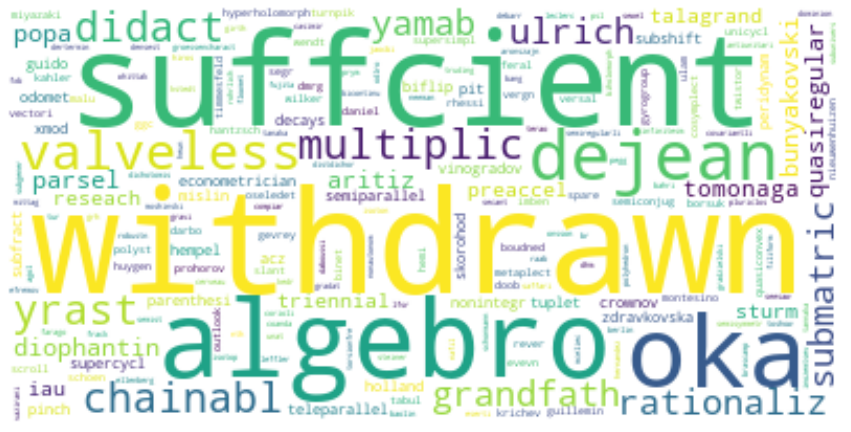

In [25]:
wordcloud = WordCloud(background_color='white').fit_words(frequencies)
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(wordcloud, interpolation='bilinear')
_ = ax.axis("off")
fig.savefig("tfidfvect_wordcloud.png", bbox_inches = 'tight', pad_inches = 0)

Above word cloud suggests that words like sufficient, withdrawn, algebro and then rationalization, multiplication, valveless are the most frequents words present in the abstract section of the documents present in our dataset.

## 4.0 Running different ML models
Splitting the dataset into training and testing set.

In [33]:
# 75 and 25 ratio
X_train, X_test, y_train, y_test = train_test_split(df["clean_abstract"], df["labels_2"], random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6000,)
(2000,)
(6000,)
(2000,)


### 4.1 Naive Baye's Classifier
A naive Bayes classifier is an algorithm for classifying objects that employs Bayes' theorem. Naive Bayes classifiers are based on the assumption of strong (or naive) independence between data point attributes.

We will be running our train and test on Naive Baye's model and measure the roc_auc score.

In [34]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()
# fit
vectorizer.fit(X_train)
# transform training data
X_train_dtm = vectorizer.transform(X_train)
# equivalently: combine fit and transform into a single step
# this is faster and what most people would do
X_train_dtm = vectorizer.fit_transform(X_train)
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test)
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
# using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

Wall time: 11.4 ms


0.9616324373162379

In [ ]:
classification_report(y_test, y_pred_class)

### 4.2 Logistic Regression Classifier
Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable. The nature of target or dependent variable is dichotomous, which means there would be only two possible classes.

We will be running our train and test on Logistic Regression model and measure the roc_auc score.

the performance of the Logistice Regression Classifier is mostly better when comapre dto the Naive Baye's but it is lot slower when compared to it as well.

In [35]:
# instantiate a logistic regression model
logreg = LogisticRegression()
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

Wall time: 3.06 s


0.9621364223804796

In [ ]:
classification_report(y_test, y_pred_class)

### 4.3 LSTM using Word2Vec
### 4.3.1 Word2Vec
Word2Vec can make good guesses about a word's meaning based on its occurrences in text given a large enough dataset. These estimates produce word associations with words in the corpus. Words such as "King" and "Queen," for example, are very similar.

We will be running our train and test on LSTM using Word2Vec and see the results.

We will be tokenizing the cleaned abstract using the split fucntion and store in the sentences list.

In [36]:
sentences = []
for sent in clean_abstract:
    sentences.append(sent.split())
sentences

[['conform',
  'properti',
  'polym',
  'melt',
  'confin',
  'two',
  'hard',
  'structureless',
  'wall',
  'investig',
  'mont',
  'carlo',
  'simul',
  'bond',
  'fluctuat',
  'model',
  'parallel',
  'perpendicular',
  'compon',
  'chain',
  'extens',
  'correl',
  'function',
  'structur',
  'factor',
  'comput',
  'compar',
  'recent',
  'theoret',
  'approach',
  'attempt',
  'go',
  'beyond',
  'flori',
  'silberberg',
  'hypothesi',
  'demonstr',
  'ultrathin',
  'film',
  'thick',
  'h',
  'smaller',
  'exclud',
  'volum',
  'screen',
  'length',
  'blob',
  'size',
  'xi',
  'diverg',
  'logarithm',
  'r',
  'n',
  'approx',
  'b',
  'c',
  'log',
  'sim',
  'correspond',
  'decreas',
  'like',
  'power',
  'law',
  'omega',
  'curvilinear',
  'distanc',
  'upon',
  'increas',
  'find',
  'contrast',
  'bulk',
  'expon',
  'importantli',
  'em',
  'give',
  'direct',
  'evid',
  'enhanc',
  'self',
  'interact',
  'segment',
  'reflect',
  'systemat',
  'deviat',
  'kratki'

Below, we will be strating the Word2Vec model to convert the words to vectors.

In [37]:
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec(sentences, min_count=10)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 3916 - Embedding Dim: 100


In [38]:
# Some validation on the quality of the Word2Vec model
print(w2v_model.wv.most_similar('result', topn=3))
print(w2v_model.wv.most_similar('made', topn=3))
print(w2v_model.wv.most_similar('newton', topn=3))
print(w2v_model.wv.most_similar('seen', topn=3))

[('final', 0.9114078283309937), ('good', 0.8657068610191345), ('best', 0.8539629578590393)]
[('clinic', 0.9750452637672424), ('benefit', 0.9722710251808167), ('assess', 0.9703413248062134)]
[('hedg', 0.9912280440330505), ('merit', 0.9909891486167908), ('devis', 0.9907400608062744)]
[('believ', 0.9917675256729126), ('beyond', 0.9908277988433838), ('crisi', 0.9903212785720825)]


### 4.3.2 Visualizing Word2Vec Embeddings with t-SNE
##### t-SNE:
t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. 

In [39]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If the word is not found in the index, return 0.
    # I realise this is the same as the word of index 0 (i.e. most frequent word),
    # but 0s will be padded later by the embedding layer (which also seems dirty,
    # but I couldn't think of a better solution right now).
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index_to_key[token]

C:\Users\farha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\farha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


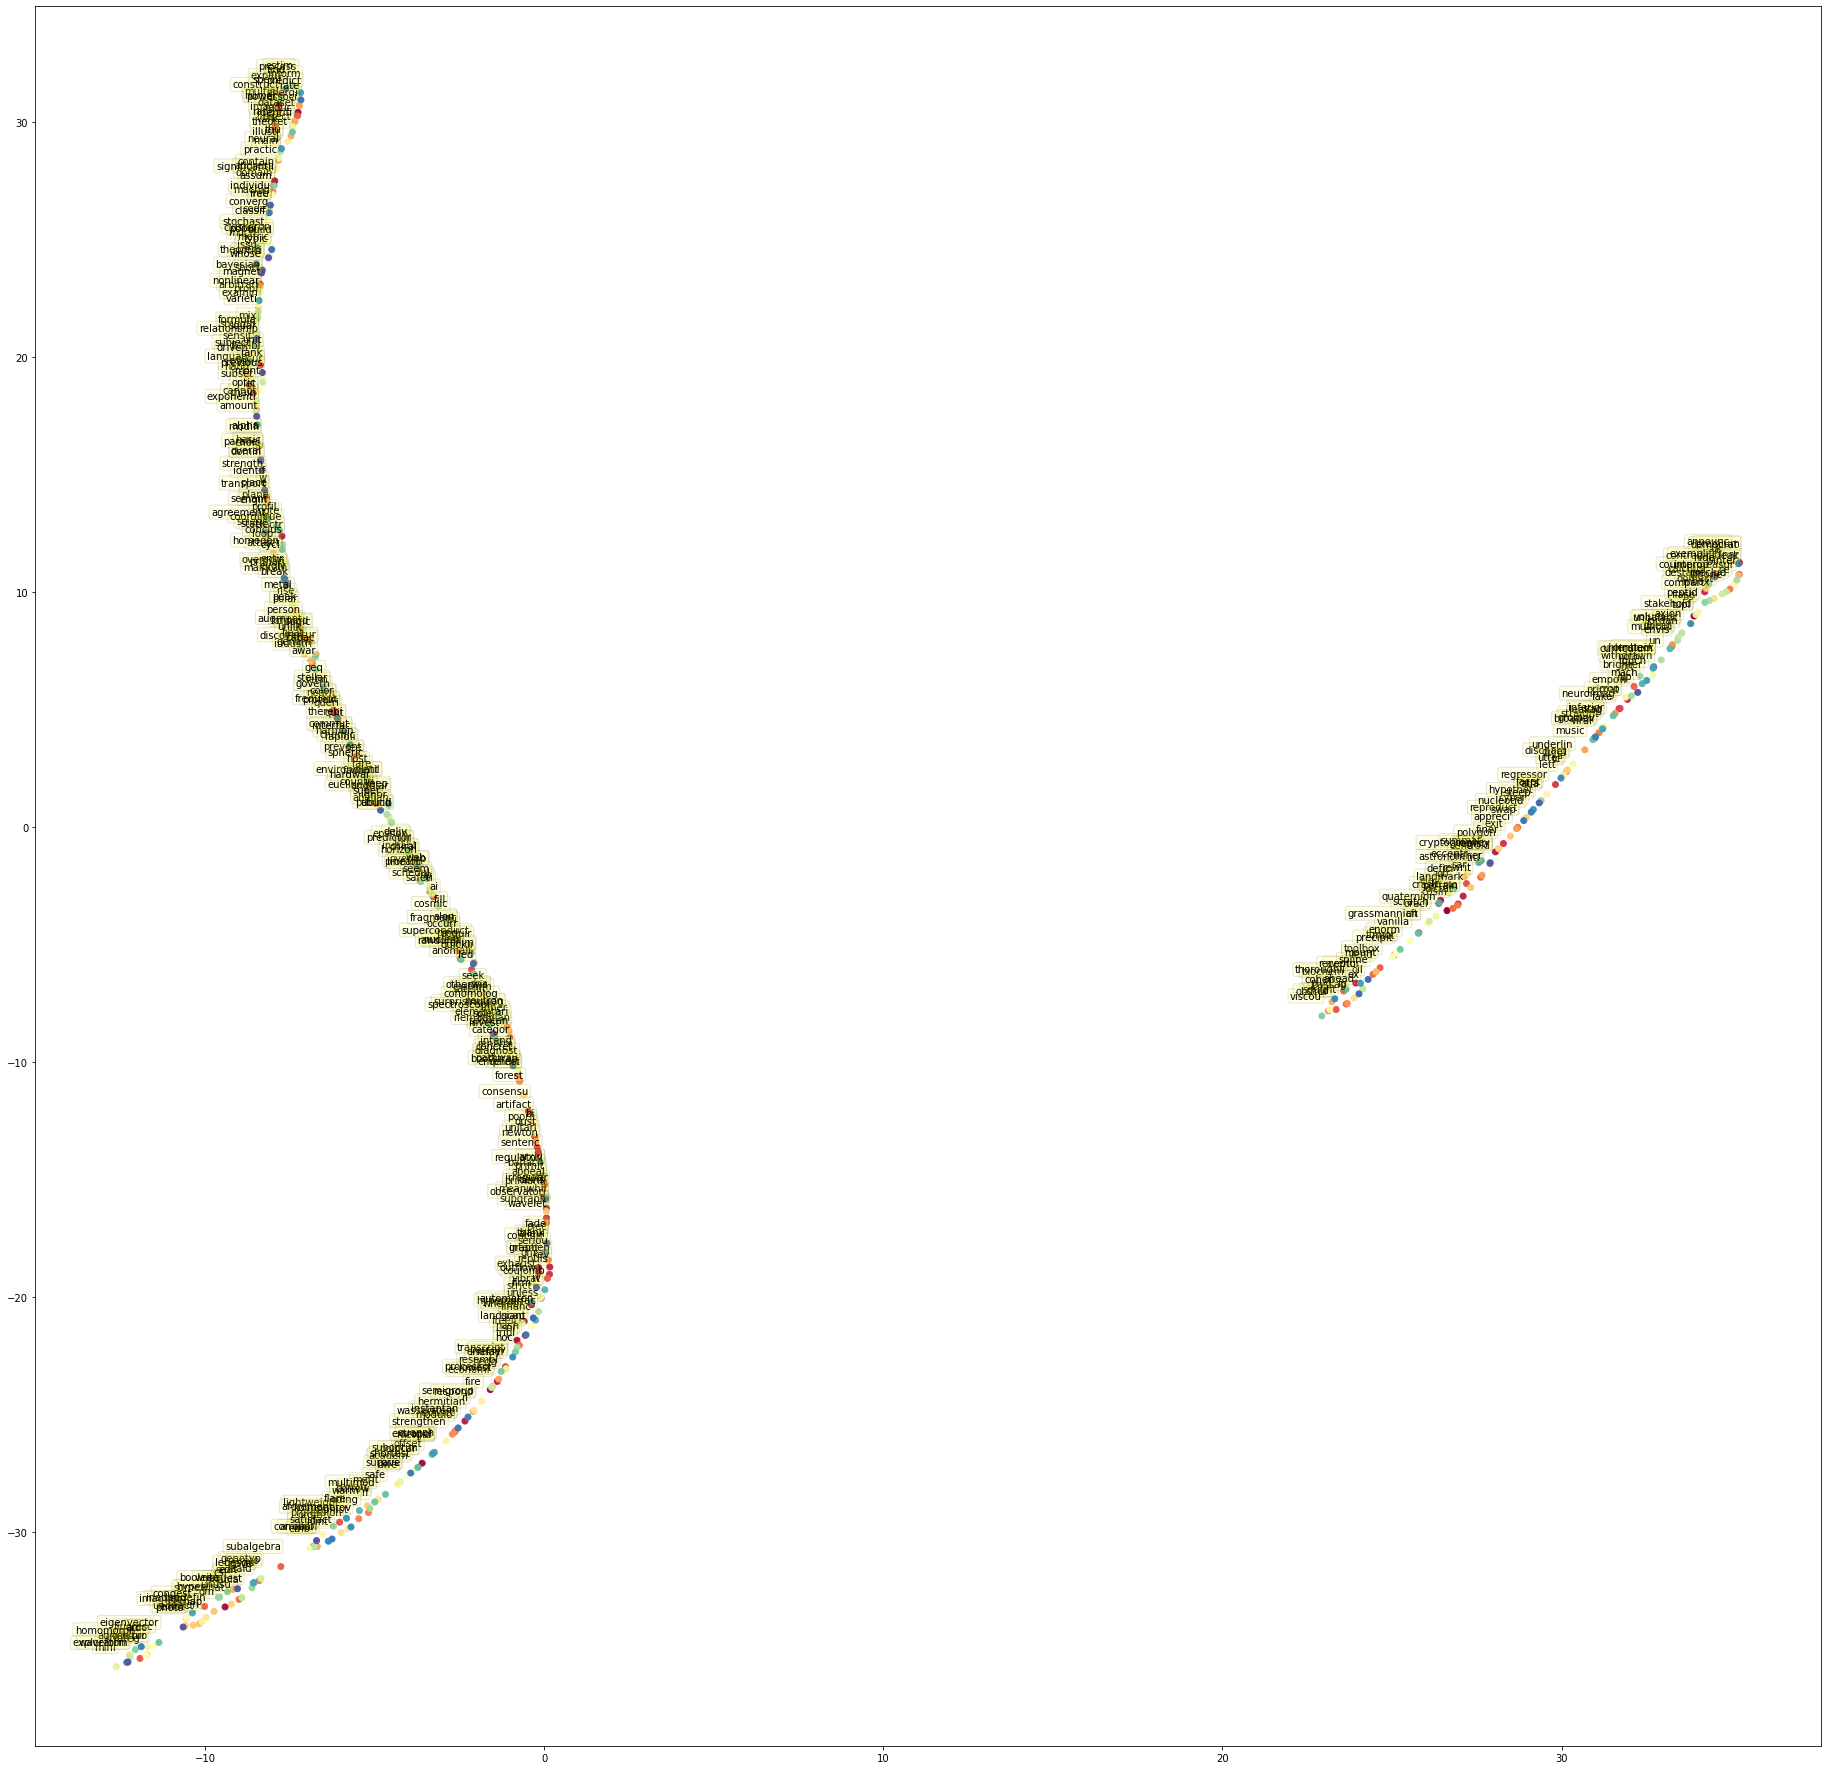

In [40]:
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model.wv.get_index(w) for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs.reshape(-1,1))

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

Below, we will be finding the maximum length of a sentence from all the sentences.

In [41]:
maxi=-1
for i,rev in enumerate(df['clean_abstract']):
  tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
print(maxi)

145


In [42]:
# total numberof extracted words.
vocab=w2v_model.wv.index_to_key
print("The total number of words are : ",len(vocab))

The total number of words are :  3916


In [43]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  3916


Below code helps us in tokenizing all the cleaned abstracts.

In [44]:
tok = Tokenizer()
tok.fit_on_texts(df['clean_abstract'])
vocab_size_1 = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(sentences)

In [45]:
max_rev_len=157  # max lenght of a review
vocab_size_1 = len(tok.word_index) + 1  # total no of words
embed_dim=100 # embedding dimension as choosen in word2vec constructor

In [46]:
# Padding sequences with 0.
set_x = pad_sequences(encd_rev, maxlen=200, dtype='int32', padding='pre', truncating='pre', value=0)
set_y = np.array(df["labels_2"])
print(set_x.shape)
print(set_y.shape)

(8000, 200)
(8000,)


Splitting the data into train and test set.

In [47]:
x_train,x_test,y_train,y_test=train_test_split(set_x,set_y,test_size=0.20)

In [48]:
vocab_size_new = int(vocab_size*df.shape[0]/1000)

### 4.3.3 Performing LSTM
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [49]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(keras.layers.Embedding(vocab_size_new, embedding_size))
# return_sequences = True
model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
#model.add(Bidirectional(LSTM(100)))
#model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3132800   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 3,294,404
Trainable params: 3,294,404
Non-trainable params: 0
_________________________________________________________________


In [50]:
%time history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
100/100 [==============================] - 113s 1s/step - loss: 1.1052 - accuracy: 0.5042 - val_loss: 0.8185 - val_accuracy: 0.6612
Epoch 2/5
100/100 [==============================] - 109s 1s/step - loss: 0.5567 - accuracy: 0.7981 - val_loss: 0.5856 - val_accuracy: 0.7862
Epoch 3/5
100/100 [==============================] - 108s 1s/step - loss: 0.3319 - accuracy: 0.8950 - val_loss: 0.5769 - val_accuracy: 0.8062
Epoch 4/5
100/100 [==============================] - 110s 1s/step - loss: 0.2039 - accuracy: 0.9409 - val_loss: 0.6468 - val_accuracy: 0.8044
Epoch 5/5
100/100 [==============================] - 111s 1s/step - loss: 0.1209 - accuracy: 0.9669 - val_loss: 0.7081 - val_accuracy: 0.8019
Wall time: 9min 10s


## 4.4 BERT
Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

To convert the numeric labels to categorical and that too in a tokenized form can be done using keras as shown below.

In [10]:
y = tf.keras.utils.to_categorical(df["labels_2"].values, num_classes=df.shape[0])
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Below, the truncated dataset is divided into 3 categories: train, validation and test sets.

The train and validation sets will be used in training the model.

In [11]:
x_train_val, x_test, y_train_val, y_test = train_test_split(df['abstract'], y, test_size=0.25)
print("X_train_val: ", x_train_val.shape)
print("X_test: ", x_test.shape)
print("y_train_val: ", y_train_val.shape)
print("y_test: ", y_test.shape)

X_train_val:  (750,)
X_test:  (250,)
y_train_val:  (750, 1000)
y_test:  (250, 1000)


In [12]:
x_train, x_test_val, y_train, y_test_val = train_test_split(x_train_val, y_train_val, test_size=0.25)
print("X_train: ", x_train.shape)
print("X_test_val: ", x_test_val.shape)
print("y_train: ", y_train.shape)
print("y_test_val: ", y_test_val.shape)

X_train:  (562,)
X_test_val:  (188,)
y_train:  (562, 1000)
y_test_val:  (188, 1000)


We are using the multilingual-preprocess model which helps us in converting the plain text inputs into the input format thats accpeted by BERT.

The multilingual sentence encoder maps text into high dimensional vectors that capture sentence-level semantics which returns a pooled_output of shape [batch_size, 768] with representations for the entire input sequences.

In [13]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [14]:
def get_embeddings(sentences):
  """ return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  """
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

In [15]:
def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, #xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  #g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

##### To get a good output from the model, we will be observing different metrics during training such as recall, precision, f1 score.

In [16]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

In [17]:
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

In [18]:
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Coverting all the inputs using the above defined preeprocessor and encoder to convert the inputs into a format thats acceptable by BERT.

In [19]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(df.shape[0], activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In the below piece of code, we will be training the model using the above converted inputs, defined accuracy functions for measuring the metrics, the train and validation datasets.

In [20]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [21]:


model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test_val, y_test_val),
                      callbacks = [earlystop_callback])

Epoch 1/20
18/18 [==============================] - 274s 9s/step - loss: 4.2571 - accuracy: 0.2509 - balanced_recall: 0.0000e+00 - balanced_precision: 0.0000e+00 - balanced_f1_score: 0.0000e+00 - val_loss: 1.8890 - val_accuracy: 0.4255 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 123s 7s/step - loss: 1.4473 - accuracy: 0.4644 - balanced_recall: 5.1808e-05 - balanced_precision: 2.2222e-04 - balanced_f1_score: 8.2709e-05 - val_loss: 1.2152 - val_accuracy: 0.6277 - val_balanced_recall: 1.2546e-04 - val_balanced_precision: 8.3333e-04 - val_balanced_f1_score: 2.1545e-04
Epoch 3/20
18/18 [==============================] - 116s 7s/step - loss: 1.1367 - accuracy: 0.6050 - balanced_recall: 2.8271e-04 - balanced_precision: 0.0013 - balanced_f1_score: 4.5688e-04 - val_loss: 1.0759 - val_accuracy: 0.6915 - val_balanced_recall: 3.0317e-04 - val_balanced_precision: 0.0016 - val_balanced_

After the model is trained, we will be looking through all the metrics using the plots to see how is the performance of teh train and validation datasets.

Finally, we will be running the prediction on test set. 

In [ ]:
def predict_class(abstract):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(abstract)]


predict_class(x_test)

## 5.0 Interpreting the results

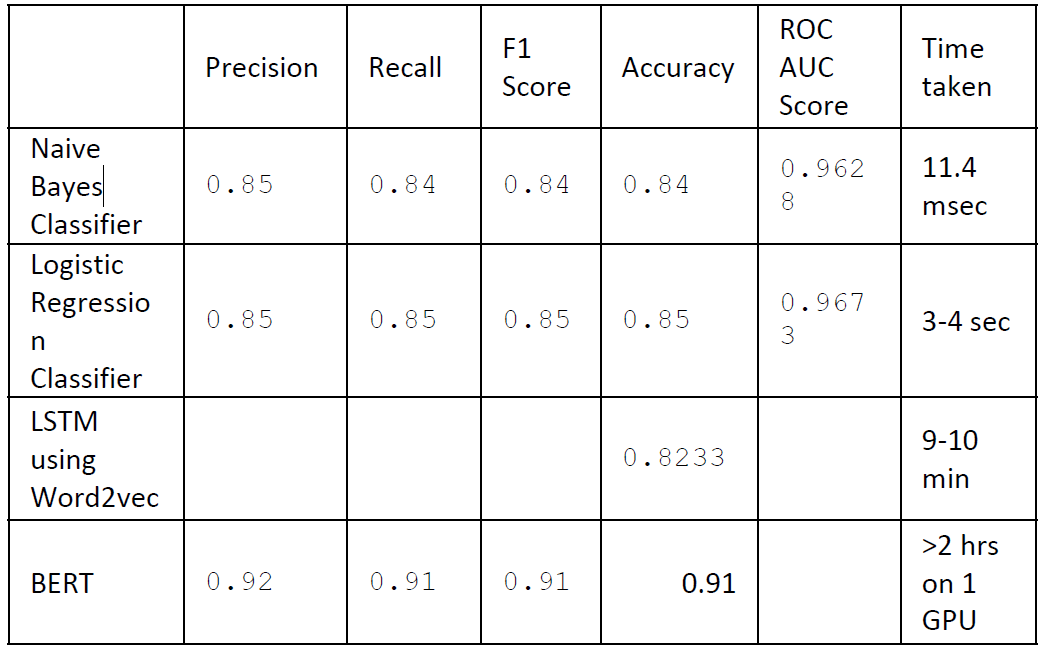

As we can see from the below table all the metrics score of all the models we can say that all the models look to be
performing great with an accuracy going above 80%.
According to the table, Deep learning with Bert pretrained model has the highest accuracy of 91%.

## Conclusion

In this project, we discussed how to apply various NLP models to a text classification use case. I compared three 
popular approaches: Bag-of-Words with Tfidf, Word Embedding with Word2Vec, and Language model with
BERT. With such great accuracy score we can say that the best model can be used for classifying papers into different
categories.